# Advanced Lane Finding Project:

## Import Dependencies

In [2]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load Images and Find Corners

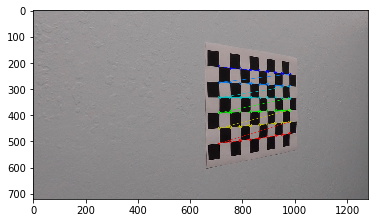

In [15]:
def load_calibration_images():
    paths = glob.glob('camera_cal/*.jpg')
    return np.array([cv2.imread(path) for path in paths])

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

def to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def find_corners(image, name = None):
    ret, corners = cv2.findChessboardCorners(to_gray(image), (9, 6), None)
    if not ret:
        print('could not find corners in image: {}'.format(name))
        return 
    
    return corners
            
def draw(image, corners):
    if corners is None:
        print('no corners to draw')
    painted = cv2.drawChessboardCorners(image, (9, 6), corners, True)
    plt.imshow(painted)

            
images = load_calibration_images()
image_num = 19

image = images[image_num]
corners = find_corners(image, image_num)
draw(image, corners)

# Get Points and Define Calibrate 

In [4]:


def get_points(images):
    obj_points = []
    img_points = []
    
    for i, image in enumerate(images):
        corners = find_corners(image, i)
        if corners is not None:
            obj_points.append(objp)
            img_points.append(corners)
    return obj_points, img_points
    

def calibrate_camera(image, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, to_gray(image).shape[::-1], None, None)
    return cv2.undistort(image, mtx, dist, None, mtx)


obj_points, img_points = get_points(images)

could not find corners in image: 0
could not find corners in image: 1
could not find corners in image: 3
could not find corners in image: 6


# Calibrate and Visualize

Text(0.5,1,'Undistorted Image')

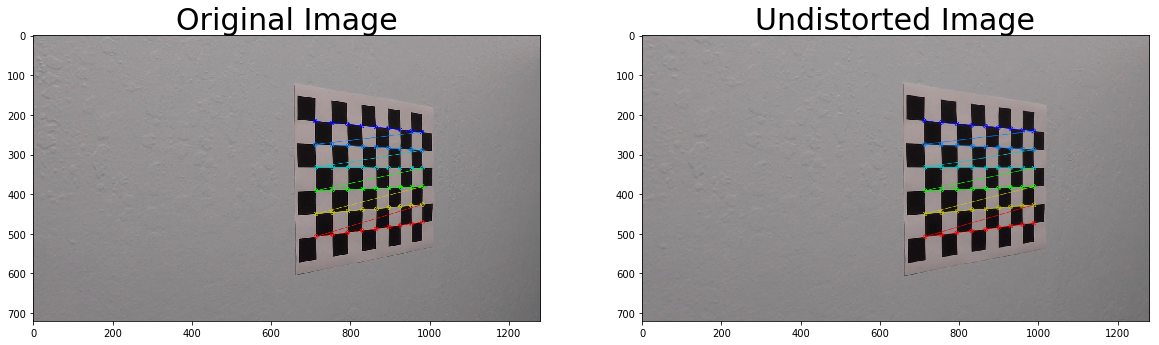

In [16]:
calibrated = calibrate_camera(image, obj_points, img_points)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(calibrated)
ax2.set_title('Undistorted Image', fontsize=30)

# Load Test Images

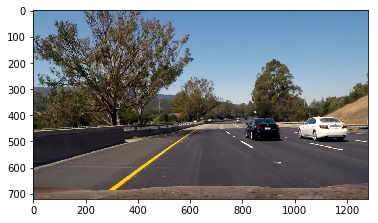

In [34]:
def load_road_images():
    road_images = []
    paths = glob.glob('test_images/*.jpg')
    for path in paths: 
        road_images.append(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))
        
    return road_images

road_images = load_road_images()    
road_image_num = 0
road_image = road_images[road_image_num]
plt.imshow(road_image)

# Undistorted Image

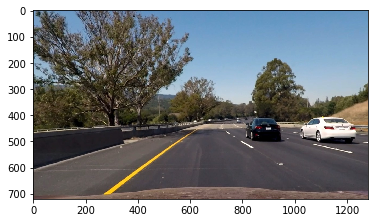

In [30]:
undistorted_image = calibrate_camera(road_image, obj_points, img_points)
plt.imshow(undistorted_image)

# Gradient & Color Threshold Testing

## Gray x threshold

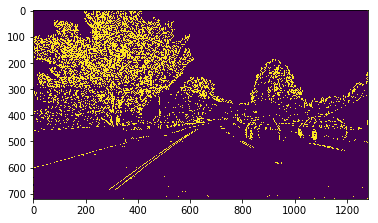

In [52]:
def x_threshold(img_channel, thresh=(0, 255)):
    sobel = cv2.Sobel(img_channel, cv2.CV_64F, 1, 0)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    thresh_min, thresh_max = thresh
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    return sbinary

x_gray_binary = x_threshold(to_gray(road_image), thresh=(20, 255))
plt.imshow(x_gray_binary)

# Warp Image